<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mohammad Hossein Rohban
</font>
<br/>
<br/>
Fall 2021

</div>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Practical Assignment 4 Pytorch Classification
            	<br/>
			</font>
    <br/>
    <br/>
<font size=4>
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

# Personal Data

In [ ]:
# Set your student number
student_number = 98101125
Name = 'Bahar'
Last_Name = 'Asadi'

SyntaxError: ignored

# Rules
- You **are** allowed to add or remove cells. 
- By running the cell below, you can see if your jupyter file is accepted or not. This cell will also **generate a python file which you'll have to upload to Quera** (as well as your jupyter file). The python file will later be validated and if the code in both files doesn't match, **your Practical Assignment won't be graded**.

In [ ]:
# remember to save your jupyter file before running this script
from validator import *

python_code = extract_python("./Q2.ipynb")
with open(f'python_code_Q2_{student_number}.py', 'w') as file:
    file.write(python_code)

ImportError: ignored

# PyTorch & MNIST Classification (50 points+5 Extra)

<font size=4>
Author: Arman Zarei
			<br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

In this assignment, you are going to learn the fundamentals of PyTorch and implement a classifier network for MNIST dataset. You can read about more details of PyTorch components from [this link](https://pytorch.org/tutorials).

In [1]:
from google.colab import files
files.upload()

Saving ae_helper.py to ae_helper.py


{'ae_helper.py': b'"""\nAUTHOR:         Ahmad Salimi (https://github.com/ahmadsalimi)\n"""\n\n\nfrom typing import Tuple\n\nfrom sklearn.datasets import fetch_openml\nimport numpy as np\nimport os\nimport torch\nfrom tqdm import tqdm\n\n\ndef get_data() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:\n    """ Downloads the MNIST data and processes the data for autoencoder problem.\n    \n    Returns:\n        Tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple of input images,\n            output images (input + 1), and the label of input images\n    """\n    X, y = fetch_openml(\'mnist_784\', return_X_y=True, cache=True)\n    X, y = X.values, y.values\n    X = X.reshape(-1, 28, 28).astype(\'float32\') / 255.0\n    y = y.astype(int)\n\n    Y = np.zeros_like(X)\n    ind = y.argsort()\n    X, y = X[ind], y[ind]\n\n    c = 0\n    for i in range(10):\n        s = (y == i).sum()\n        ss = (y == (i + 1) % 10).sum()\n        if s <= ss:\n            Y[c:c+s] = X[c+s:c+2*s]\n        elif i < 

### Setup

In [2]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from ae_helper import init_mnist_subset_directories
import math
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

#### Loading dataset

In [4]:
mnist_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Autograd

Autograd is PyTorch's automatic differentiation engine that powers neural network training. In essence it helps us to calculate derivatives and updating parameters. To read more about Autograd and Computational Graph visit [this link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)

Let us define two parameters: $p_1$ and $p_2$. 

In [ ]:
p1 = torch.tensor([3.], requires_grad=True)
p2 = torch.tensor([7.], requires_grad=True)

Now define a variable $L$ as below:

$L = 3 \times p_1^3 - 7 \times p_2^2 + sin(p1) \times p_2^2$

In [ ]:
# Place your code here (2.5 Points)
L = torch.add(torch.add(torch.mul(torch.pow(p1, 3), 3), torch.mul(torch.pow(p2, 2), -7)), torch.mul(torch.sin(p1), torch.pow(p2, 2)))
## Hint: You can use torch.sin for calculation of sin(p1)


Now you have to calculate the gradient of $p_1$ and $p_2$ with respect to $L$. First do it by hand and write the mathematical expression in the below cell both for $p_1$ and $p_2$. Then evaluate them at $3$ and $7$ (acording to the initialization)

Place your expressions here **(2.5 Points)**


$\frac{dL}{dp_1} = 9 p_{1}^{2} + p_{2}^{2} \times cos(p_1)$ 

$\frac{dL}{dp_2} = - 14 p_{2} + 2sin(p_{1}) \times p_{2}$

$\frac{dL}{dp_1}(3, 7) = 9 \times 3^2 + 7^2 \times cos(3) = 32.4904$

$\frac{dL}{dp_2}(3, 7) = -14 \times 7 + 2 sin(3) \times 7 = -96.0243$

In [ ]:
# Place your code here (optional)
## For calculation of dL/dp in the given point

Now let's calculate this using pytorch. The below code will construct the computational graph and stores the gradient of each variable inside of it.

In [ ]:
L.backward()

Check whether the result of your calculations is the same with the autograd's output.

In [ ]:
print(f"P_1 grad: {p1.grad.item()}\nP_2 grad: {p2.grad.item()}")

P_1 grad: 32.4903678894043
P_2 grad: -96.02432250976562


## Transform 

Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training. For more details, you can read [this link](https://pytorch.org/vision/stable/transforms.html)

There are many transformations that are already implemented inside pytorch that you can use. Here we are going to implement some transformation from scratch using PyTorch's framework.

#### Random Horizontal Flip Transformation

Define a transformation that flips the image (horizontally) with probability of $p$. In order to implement a simple transformation class, you need to have two methods: `__init__` and `__call__` (which receives the image)

In [ ]:
class RandomHorizontalFlip(object):
    """Horizontally flip the given image randomly with a given probability."""

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img):
      shape = img.shape # saving the shape for reshaping at the end
      img = img[0] # img is 3-dimensional according to our dataset (1, 28, 28)
      if torch.rand(1) < self.p:
        return torch.fliplr(img).reshape(shape)
      return img.reshape(shape)

#### Random Color Swap

Now that you have learned how to implement a transformation class, let's build another one. Define a transformation which swaps the colors (in the gray scale image) with probability of $p$. For example, if the given image had a white colored number with a black background, it should output an image with black colored number and a white background.

**Hint:** for a given input $x$, you can concider the swapped color version of it as $x_{new} = m - x$ where $m$ is the maximum value in image $x$

In [ ]:
# Place your code here (5 Points)
class RandomColorSwap(object):
  def __init__(self, p=0.5):
        self.p = p
  def __call__(self, x):
    max_val = torch.max(x)
    if torch.rand(1) < self.p:
      return max_val - x
    return x

### Evaluation of transformations

Now, let's apply these transformations on some images of our dataset. You can stack different transformation using `Compose`

In [ ]:
trans = transforms.Compose([
  RandomHorizontalFlip(p=0.7),
  RandomColorSwap()
])

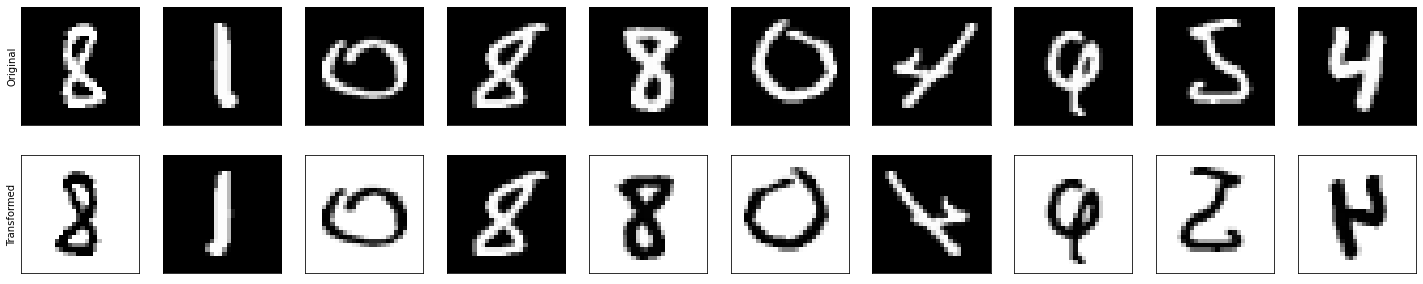

In [ ]:
num_imgs = 10
fig, axs = plt.subplots(2, num_imgs, figsize=(25, 5))
for i, idx in enumerate(torch.randint(0, len(mnist_dataset), [num_imgs])):
    x, y = mnist_dataset[idx]
    axs[0, i].imshow(x[0], cmap='gray')
    axs[1, i].imshow(trans(x)[0], cmap='gray')
    for k in range(2):
        axs[k, i].set_yticks([])
        axs[k, i].set_xticks([])

axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("Transformed");

What we expect to see is that, some of them are fliped horizontally, some swapped in color, and some both.

## Dataset

In this section, we are going to implement a dataset class. Inside `torchvision.datasets` there are many Datasets that are already implemented and ready to use. But, in many situations it's necessary to implement one by your self.

Run the below cell to initialize our dataset

In [ ]:
dataset_path = "new_mnist"
init_mnist_subset_directories(mnist_dataset, dataset_path)

100%|██████████| 5000/5000 [00:02<00:00, 2164.76it/s]


If you take a look at `new_mnist` directory which is created in the directory you are working in, you see that it contains 10 folders with names from `0` to `9` indicating the label of the images inside it. Inside each, some files with name `data_{number}.pth` exist. Each `.pth` file is an image.

Now you have to implement a Dataset on top of these files.
The methods that you should implement in a Dataset (as you can see in the code) is as described below:
- `__init__`: In our example assume that it only accepts `root_dir` and `transform` as it's parameters (You should apply the transformations before outputing the data)
- `__len__`: Should return the number of data in your dataset
- `__getitem__`: which receives an index, should return the data at the given index (which is a tuple here, containing image and the corresponding label) 

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, root_dir, transform=RandomHorizontalFlip):
        # Place your code here (4 Points)
        ## Hint: Use os.listdir(some_path) to get the list of files
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        folders = os.listdir(root_dir)
        images = []
        labels = []
        for folder in folders:
            path =os.path.join(root_dir, folder)
            # path = root_dir + "/" + folder
            single_folder = os.listdir(path)
            for file in single_folder:
                img = transform(torch.load(os.path.join(path, file)))
                images.append(img)
                labels.append(folder)
        self.dataset = images
        self.labels = labels
        
    def __len__(self):
        # Place your code here (1 Points)
        return len(self.dataset)

    def __getitem__(self, idx):
        # Place your code here (3 Points)
        ## Return a tuple (image, label)
        return self.dataset[idx], self.labels[idx]

After you defined your dataset, let's use it.

In [ ]:
my_dataset = MNISTDataset(root_dir=dataset_path, transform=RandomColorSwap())
len(my_dataset)

5000

Visualize 10 samples (randomely) from your dataset with their labels

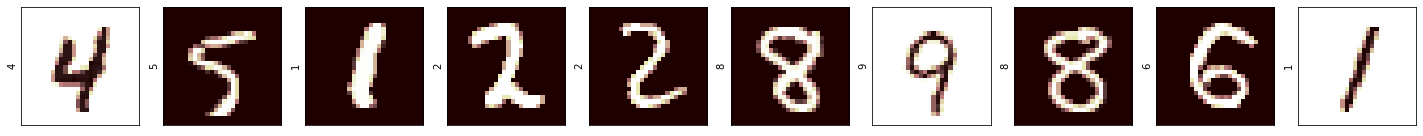

In [ ]:
# Place your code here (2 Points)
num_imgs = 10
fig, axs = plt.subplots(1, num_imgs, figsize=(25, 5))
for i, idx in enumerate(torch.randint(0, len(my_dataset), [num_imgs])):
    x, y = my_dataset[idx]
    axs[i].imshow(x[0], cmap='pink')
    axs[i].set_ylabel(y)
    for k in range(1):
        axs[i].set_yticks([])
        axs[i].set_xticks([])

## MNIST Classification

### Model
Define your model (Based on what you have learned in the workshop). I highly encourage you to try different models with different layers in order to achieve a better accuracy

**Notice:** You cannot use convolution layers in your model 

In [5]:
# Place your code here (5 points)
class DigitRecognizer(nn.Module):
  def __init__(self):
        super(DigitRecognizer,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10)
        self.relu = nn.ReLU()

  def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x

In [6]:
model = DigitRecognizer().to(device)
model

DigitRecognizer(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

### Dataset and Dataloader

Prepare datasets and dataloader for train/test. We use MNIST dataset that is already implemented inside `torchvision.datasets`.

 You need to split the `mnist_dataset` into `train_dataset` and `val_dataset`. 
 
 You can also define more transformations that you think it would help the training process **(Optional)**.

In [7]:
transform_compose = transforms.Compose([
    transforms.ToTensor(),
    # Place your code here
])

mnist_dataset = datasets.MNIST(root='dataset', train=True, download=True, transform=transform_compose)
# Place your code here (1 points)
## Notice: Split mnist_dataset into train_dataset and val_dataset
train_size = int(0.99 * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_dataset, [train_size, val_size])
# End of block for your code placement
test_dataset = datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



### Criterion and Optimizer

you have to tune the `learning_rate` yourself (Based on your training process)

In [8]:
criterion = nn.CrossEntropyLoss()
learning_rate=1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train your model

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). You also need to store train/validation loss at each epoch in order to visualize them the after training is done.

In [9]:
num_epochs= 60

train_loss_arr, val_loss_arr = [], []
for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0

    train_epoch_true = 0
    train_epoch_all = 0
    model.train()
    # Place your code here (5 points)
    ## Hint: Loop throught train_loader, get images with their labels and train the model
    ## Hint 2: To update train_loss inside the loop use "train_loss += batch_loss * batch_size""
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        x = x.reshape((-1, 784))
        optimizer.zero_grad()
        p = model(x)

        loss = criterion(p, y)
        train_loss += float(loss.item() * p.shape[0])

        predictions = p.argmax(-1)
        train_epoch_all += len(predictions)
        train_epoch_true += (predictions == y).sum()

        loss.backward()

        optimizer.step()
  
    val_epoch_true = 0
    val_epoch_all = 0
    model.eval()            
    # Place your code here (4 points)
    ## Hint: Loop throught val_loader, get images with their labels and evaluate the model
    ## Hint 2: To update val_loss inside the loop use "val_loss += batch_loss * batch_size""
    with torch.no_grad():
      for i, (x, y) in enumerate(val_loader):
        x = x.to(device)
        y = y.to(device)
        x = x.reshape((-1, 784))
        p = model(x)

        loss = criterion(p, y)
        val_loss += float(loss.item() * p.shape[0])

        predictions = p.argmax(-1)
        val_epoch_all += len(predictions)
        val_epoch_true += (predictions == y).sum()

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)

    print(f"[Epoch {epoch}]\t"
        f"Train Loss: {train_loss:.4f}\t"
        f"Validation Loss: {val_loss:.4f}")

[Epoch 0]	Train Loss: 0.7492	Validation Loss: 0.3658
[Epoch 1]	Train Loss: 0.3180	Validation Loss: 0.2847
[Epoch 2]	Train Loss: 0.2711	Validation Loss: 0.2434
[Epoch 3]	Train Loss: 0.2400	Validation Loss: 0.2113
[Epoch 4]	Train Loss: 0.2140	Validation Loss: 0.1869
[Epoch 5]	Train Loss: 0.1928	Validation Loss: 0.1631
[Epoch 6]	Train Loss: 0.1751	Validation Loss: 0.1462
[Epoch 7]	Train Loss: 0.1603	Validation Loss: 0.1334
[Epoch 8]	Train Loss: 0.1471	Validation Loss: 0.1213
[Epoch 9]	Train Loss: 0.1360	Validation Loss: 0.1120
[Epoch 10]	Train Loss: 0.1262	Validation Loss: 0.1057
[Epoch 11]	Train Loss: 0.1173	Validation Loss: 0.1035
[Epoch 12]	Train Loss: 0.1093	Validation Loss: 0.1016
[Epoch 13]	Train Loss: 0.1019	Validation Loss: 0.0893
[Epoch 14]	Train Loss: 0.0957	Validation Loss: 0.0809
[Epoch 15]	Train Loss: 0.0901	Validation Loss: 0.0875
[Epoch 16]	Train Loss: 0.0844	Validation Loss: 0.0807
[Epoch 17]	Train Loss: 0.0796	Validation Loss: 0.0786
[Epoch 18]	Train Loss: 0.0751	Validati

#### Plot train/validation loss

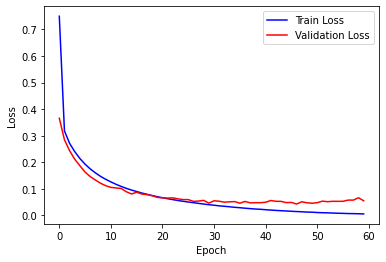

In [10]:
# Place your code here (1 points)
plt.plot(train_loss_arr,'blue',label = 'Train Loss')
plt.plot(val_loss_arr,'red',label = 'Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Evaluation

Evaluate your model on test set. you have to report both loss and accuracy.

In order to get the full score of this section, you need to achieve an accuracy above $95\%$ and to get the extra points, your accuracy should be above $98\%$ 

**Notice:** You should use test set only for evaluation of your model.

In [ ]:
# Place your code here (4 points + 5 Extra)
model.eval()
accuracy = 0.0
total = 0.0
test_loss = 0
with torch.no_grad():
    for test in test_loader:
      x, y = test
      x = x.to(device)
      y = y.to(device)
      x = x.reshape((-1, 784))
      p = model(x)
      loss = criterion(p, y)
      test_loss += float(loss.item() * p.shape[0])
      predicted = torch.max(p.data, 1)[1]
      total += y.size(0)
      accuracy += (predicted == y).sum().item()

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")
accuracy = (100 * accuracy / total)
print(f"accuracy: {accuracy:.2f}")

Test Loss: 0.0887
accuracy: 97.67


### Visualization of wrong prediction

Visualize $8$ samples (along with original label and model's prediction) from test set which are labeled wrong by your model

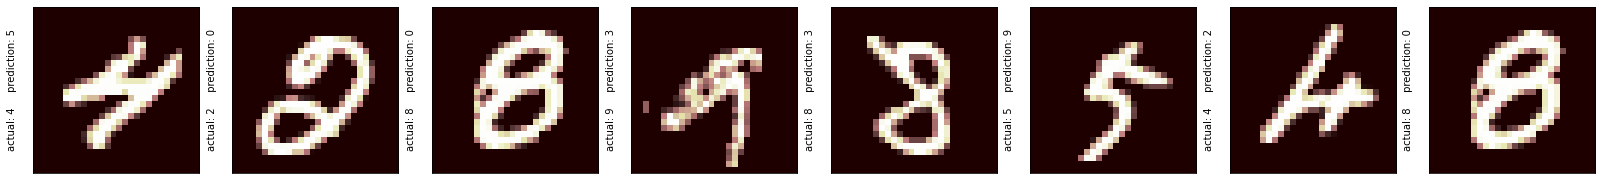

In [ ]:
# Place your code here (5 points)
not_valid = []
predicted_list = []
with torch.no_grad():
    for test in test_loader:
      x, y = test
      imgs = x.to(device).reshape((-1, 784))
      y = y.to(device)
      p = model(imgs)
      predicted = torch.max(p.data, 1)[1]
      total += y.size(0)
      for i in range(len(predicted)):
        p = predicted[i].item()
        l = y[i].item()
        if p != l:
          not_valid.append(x[i])
          predicted_list.append("actual: " + str(l) + "     prediction: "+ str(p))

num_imgs = 8
fig, axs = plt.subplots(1, num_imgs, figsize=(28, 8))
for i, idx in enumerate(torch.randint(0, len(not_valid), [num_imgs])):
    k = not_valid[idx]
    axs[i].imshow(k[0], cmap='pink')
    axs[i].set_ylabel(predicted_list[idx] + "\n")
    for k in range(1):
        axs[i].set_yticks([])
        axs[i].set_xticks([])